In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
from tqdm.notebook import tqdm
from PIL import Image
import os
from torchinfo import summary

In [5]:
## parameters
### 五张图片一组
step=5

### read images

In [6]:
##path = r'C:\Users\liuya\Downloads\3d_printing_research\clipped_samples'
path = r'C:\Users\liuya\Downloads\3d_printing_research\clipped_samples_otsu'
image_list = os.listdir(path)

In [7]:
full_path = os.path.join(path, image_list[350])
np.array(Image.open(full_path).convert('RGB')).shape

(250, 730, 3)

In [8]:
image_ls = []

for i in tqdm(image_list):
    full_path = os.path.join(path, i)
    img = Image.open(full_path).convert('L')
    img_array = np.asarray(img)
    image_ls.append(img_array)

  0%|          | 0/4046 [00:00<?, ?it/s]

In [9]:
### normalize
data_input = np.array(image_ls)
### np.divide((data_input-np.min(data_input)), (np.max(data_input)-np.min(data_input)))

In [10]:
data_input = np.divide((data_input-np.min(data_input)), (np.max(data_input)-np.min(data_input)))

In [11]:
data_input = torch.tensor(data_input[:,None,:,:], dtype=torch.float32)

In [12]:
data_input.shape

torch.Size([4046, 1, 250, 730])

### build the model

In [13]:
class Conv_NN_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d1 = nn.Conv2d(1, 16, kernel_size=(6,6))
        self.maxpool2d1 = nn.MaxPool2d((3,3), return_indices=True)
        self.conv2d2 = nn.Conv2d(16, 8, kernel_size=(6,6))
        self.maxpool2d2 = nn.MaxPool2d((3,3), return_indices=True)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=15600, out_features=2560)
        self.linear2 = nn.Linear(in_features=2560, out_features=128)
        self.linear3 = nn.Linear(in_features=128, out_features=64)
        self.linear4 = nn.Linear(in_features=64, out_features=6)
        
    def forward(self, x):
        batch_size = x.shape[0]
        ## n_tau = x.shape[2]
        ## 1 means 1 channel, multiply sample size with tau to create this many of 1*W vectors
        ## x = x.view((-1, 1, x.shape[3], x.shape[4]))
        output = F.relu(self.conv2d1(x))
        output, indices1 = self.maxpool2d1(output)
        output = F.relu(self.conv2d2(output))
        output, indices2 = self.maxpool2d2(output)
        output = self.flatten(output)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = self.linear4(output)
        #back to the previous dimension (sample_size, tau)
        #output = output.view((batch_size, n_tau, -1))
        return output, indices1, indices2

In [14]:
class Conv_NN_decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(6, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 2560)
        self.linear4 = nn.Linear(2560, 15600)
        self.maxunpool2d1 = nn.MaxUnpool2d((3,3))
        ## self.conv2d1 = nn.Conv2d(8, 16, kernel_size=(6,6), padding=(5,5))
        self.conv2d1 = nn.ConvTranspose2d(8, 16, kernel_size=(6,6))
        self.maxunpool2d2 = nn.MaxUnpool2d((3,3))
        ## self.conv2d2 = nn.Conv2d(16, 1, kernel_size=(6,6), padding=(5,5))
        self.conv2d2 = nn.ConvTranspose2d(16, 1, kernel_size=(6,6))
        self.sigmoid1 = nn.Sigmoid()
        #self.pad = nn.ConstantPad2d((9,9,58,0), 0)

        
    def forward(self, x, indices1, indices2):
        ## x = x.contiguous().view((-1, x.shape[2]))
        output = F.relu(self.linear1(x))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = F.relu(self.linear4(output))
        output = output.view((output.shape[0], 8, 25, 78))
        output = self.maxunpool2d1(output, indices2, output_size=torch.Size([output.shape[0], 8, 76, 236]))
        output = F.relu(self.conv2d1(output))
        output = self.maxunpool2d2(output, indices1, output_size=torch.Size([output.shape[0], 16, 245, 725]))
        output = self.conv2d2(output)
        output = self.sigmoid1(output)
        #output = self.pad(output)
        #back to original size
        #output = output.view((-1, 1, 5, output.shape[2], output.shape[3]))
        return output

In [15]:
class net(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.Conv_NN_encoder = args[0]
        self.Conv_NN_decoder = args[1]
    
    def forward(self, x):
        output, indc1, indc2 = self.Conv_NN_encoder(x)
        output = self.Conv_NN_decoder(output, indc1, indc2)
        return output

In [16]:
model = net(Conv_NN_encoder(), Conv_NN_decoder())

In [17]:
summary(model,input_size=(10,1,250,730))

Layer (type:depth-idx)                   Output Shape              Param #
net                                      --                        --
├─Conv_NN_encoder: 1-1                   [10, 6]                   --
│    └─Conv2d: 2-1                       [10, 16, 245, 725]        592
│    └─MaxPool2d: 2-2                    [10, 16, 81, 241]         --
│    └─Conv2d: 2-3                       [10, 8, 76, 236]          4,616
│    └─MaxPool2d: 2-4                    [10, 8, 25, 78]           --
│    └─Flatten: 2-5                      [10, 15600]               --
│    └─Linear: 2-6                       [10, 2560]                39,938,560
│    └─Linear: 2-7                       [10, 128]                 327,808
│    └─Linear: 2-8                       [10, 64]                  8,256
│    └─Linear: 2-9                       [10, 6]                   390
├─Conv_NN_decoder: 1-2                   [10, 1, 250, 730]         --
│    └─Linear: 2-10                      [10, 64]               

### train the model

In [40]:
def train(model, device, train_loader, optimizer, epoch):
    
    model.train() #trian model
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        ##calculate loss
        ##loss = 0
        #for i in range(data.shape[0]):
            #loss += F.mse_loss(output[i], data[i], reduction='sum')
        #loss /= data.shape[0]
        #loss = F.mse_loss(output, data)
        loss = F.binary_cross_entropy(output, data)
        loss.backward()
        optimizer.step()
        # print result every 10 batch
        if batch_idx % 10 == 0:
            print('Train Epoch: {} ... Batch: {} ... Loss: {:.8f}'.format(epoch, batch_idx, loss))

In [41]:
def test(model, device, test_loader):
    model.eval() #evaluate model
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            #calculate sum loss
            test_loss += F.mse_loss(output, data, reduction='sum').item()
    
        test_loss /= len(test_loader.dataset)
        print('------------------- Test set: Average loss: {:.4f} ... Samples: {}'.format(test_loss, len(test_loader.dataset)))

### train and split

In [42]:
train_window_, val_window_ = train_test_split(data_input, test_size=0.1, random_state=2022)

In [43]:
train_loader = torch.utils.data.DataLoader(train_window_, batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_window_, batch_size=16,shuffle=False)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
model = model.to(device)

In [79]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [80]:
epochs = 50

In [81]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 ... Batch: 0 ... Loss: 0.03098008
Train Epoch: 1 ... Batch: 10 ... Loss: 0.03010960
Train Epoch: 1 ... Batch: 20 ... Loss: 0.03011408
Train Epoch: 1 ... Batch: 30 ... Loss: 0.03034727
Train Epoch: 1 ... Batch: 40 ... Loss: 0.03039216
Train Epoch: 1 ... Batch: 50 ... Loss: 0.03038430
Train Epoch: 1 ... Batch: 60 ... Loss: 0.03011596
Train Epoch: 1 ... Batch: 70 ... Loss: 0.03068490
Train Epoch: 1 ... Batch: 80 ... Loss: 0.03028410
Train Epoch: 1 ... Batch: 90 ... Loss: 0.03090384
Train Epoch: 1 ... Batch: 100 ... Loss: 0.03101928
Train Epoch: 1 ... Batch: 110 ... Loss: 0.03101949
Train Epoch: 1 ... Batch: 120 ... Loss: 0.03029856
Train Epoch: 1 ... Batch: 130 ... Loss: 0.03027695
Train Epoch: 1 ... Batch: 140 ... Loss: 0.03100871
Train Epoch: 1 ... Batch: 150 ... Loss: 0.03023774
Train Epoch: 1 ... Batch: 160 ... Loss: 0.03030810
Train Epoch: 1 ... Batch: 170 ... Loss: 0.03044361
Train Epoch: 1 ... Batch: 180 ... Loss: 0.03095135
Train Epoch: 1 ... Batch: 190 ... Loss: 0.

Train Epoch: 7 ... Batch: 160 ... Loss: 0.03083644
Train Epoch: 7 ... Batch: 170 ... Loss: 0.03091392
Train Epoch: 7 ... Batch: 180 ... Loss: 0.03067065
Train Epoch: 7 ... Batch: 190 ... Loss: 0.03076554
Train Epoch: 7 ... Batch: 200 ... Loss: 0.03077504
Train Epoch: 7 ... Batch: 210 ... Loss: 0.03071808
Train Epoch: 7 ... Batch: 220 ... Loss: 0.03053991
------------------- Test set: Average loss: 1809.4584 ... Samples: 405
Train Epoch: 8 ... Batch: 0 ... Loss: 0.03047618
Train Epoch: 8 ... Batch: 10 ... Loss: 0.03027867
Train Epoch: 8 ... Batch: 20 ... Loss: 0.03085956
Train Epoch: 8 ... Batch: 30 ... Loss: 0.02932455
Train Epoch: 8 ... Batch: 40 ... Loss: 0.03004052
Train Epoch: 8 ... Batch: 50 ... Loss: 0.03070153
Train Epoch: 8 ... Batch: 60 ... Loss: 0.03066063
Train Epoch: 8 ... Batch: 70 ... Loss: 0.03029546
Train Epoch: 8 ... Batch: 80 ... Loss: 0.03067393
Train Epoch: 8 ... Batch: 90 ... Loss: 0.03018887
Train Epoch: 8 ... Batch: 100 ... Loss: 0.03012682
Train Epoch: 8 ... Bat

Train Epoch: 14 ... Batch: 60 ... Loss: 0.03045804
Train Epoch: 14 ... Batch: 70 ... Loss: 0.02987389
Train Epoch: 14 ... Batch: 80 ... Loss: 0.03042436
Train Epoch: 14 ... Batch: 90 ... Loss: 0.03091628
Train Epoch: 14 ... Batch: 100 ... Loss: 0.03031178
Train Epoch: 14 ... Batch: 110 ... Loss: 0.03058370
Train Epoch: 14 ... Batch: 120 ... Loss: 0.03008950
Train Epoch: 14 ... Batch: 130 ... Loss: 0.03002504
Train Epoch: 14 ... Batch: 140 ... Loss: 0.03013750
Train Epoch: 14 ... Batch: 150 ... Loss: 0.03044536
Train Epoch: 14 ... Batch: 160 ... Loss: 0.03091330
Train Epoch: 14 ... Batch: 170 ... Loss: 0.02962408
Train Epoch: 14 ... Batch: 180 ... Loss: 0.03123084
Train Epoch: 14 ... Batch: 190 ... Loss: 0.03061803
Train Epoch: 14 ... Batch: 200 ... Loss: 0.03058584
Train Epoch: 14 ... Batch: 210 ... Loss: 0.03108570
Train Epoch: 14 ... Batch: 220 ... Loss: 0.03018440
------------------- Test set: Average loss: 1791.8280 ... Samples: 405
Train Epoch: 15 ... Batch: 0 ... Loss: 0.03070282

Train Epoch: 20 ... Batch: 190 ... Loss: 0.03008792
Train Epoch: 20 ... Batch: 200 ... Loss: 0.03070601
Train Epoch: 20 ... Batch: 210 ... Loss: 0.03056814
Train Epoch: 20 ... Batch: 220 ... Loss: 0.03038485
------------------- Test set: Average loss: 1793.6436 ... Samples: 405
Train Epoch: 21 ... Batch: 0 ... Loss: 0.03084764
Train Epoch: 21 ... Batch: 10 ... Loss: 0.03073030
Train Epoch: 21 ... Batch: 20 ... Loss: 0.03086084
Train Epoch: 21 ... Batch: 30 ... Loss: 0.02997310
Train Epoch: 21 ... Batch: 40 ... Loss: 0.03064769
Train Epoch: 21 ... Batch: 50 ... Loss: 0.03022555
Train Epoch: 21 ... Batch: 60 ... Loss: 0.03077293
Train Epoch: 21 ... Batch: 70 ... Loss: 0.03069386
Train Epoch: 21 ... Batch: 80 ... Loss: 0.03018864
Train Epoch: 21 ... Batch: 90 ... Loss: 0.03106033
Train Epoch: 21 ... Batch: 100 ... Loss: 0.03047212
Train Epoch: 21 ... Batch: 110 ... Loss: 0.03157052
Train Epoch: 21 ... Batch: 120 ... Loss: 0.03042210
Train Epoch: 21 ... Batch: 130 ... Loss: 0.02972288
Trai

Train Epoch: 27 ... Batch: 80 ... Loss: 0.03084150
Train Epoch: 27 ... Batch: 90 ... Loss: 0.03016685
Train Epoch: 27 ... Batch: 100 ... Loss: 0.03070737
Train Epoch: 27 ... Batch: 110 ... Loss: 0.03020505
Train Epoch: 27 ... Batch: 120 ... Loss: 0.03038344
Train Epoch: 27 ... Batch: 130 ... Loss: 0.03027429
Train Epoch: 27 ... Batch: 140 ... Loss: 0.03085800
Train Epoch: 27 ... Batch: 150 ... Loss: 0.03045336
Train Epoch: 27 ... Batch: 160 ... Loss: 0.02994689
Train Epoch: 27 ... Batch: 170 ... Loss: 0.03073270
Train Epoch: 27 ... Batch: 180 ... Loss: 0.03073730
Train Epoch: 27 ... Batch: 190 ... Loss: 0.03017286
Train Epoch: 27 ... Batch: 200 ... Loss: 0.03109417
Train Epoch: 27 ... Batch: 210 ... Loss: 0.03061178
Train Epoch: 27 ... Batch: 220 ... Loss: 0.03029581
------------------- Test set: Average loss: 1793.5086 ... Samples: 405
Train Epoch: 28 ... Batch: 0 ... Loss: 0.03030227
Train Epoch: 28 ... Batch: 10 ... Loss: 0.03079493
Train Epoch: 28 ... Batch: 20 ... Loss: 0.03038248

Train Epoch: 33 ... Batch: 210 ... Loss: 0.02935810
Train Epoch: 33 ... Batch: 220 ... Loss: 0.03065548
------------------- Test set: Average loss: 1791.5324 ... Samples: 405
Train Epoch: 34 ... Batch: 0 ... Loss: 0.03065595
Train Epoch: 34 ... Batch: 10 ... Loss: 0.03009056
Train Epoch: 34 ... Batch: 20 ... Loss: 0.03051604
Train Epoch: 34 ... Batch: 30 ... Loss: 0.02967848
Train Epoch: 34 ... Batch: 40 ... Loss: 0.03052318
Train Epoch: 34 ... Batch: 50 ... Loss: 0.03039561
Train Epoch: 34 ... Batch: 60 ... Loss: 0.03074996
Train Epoch: 34 ... Batch: 70 ... Loss: 0.03061236
Train Epoch: 34 ... Batch: 80 ... Loss: 0.03055793
Train Epoch: 34 ... Batch: 90 ... Loss: 0.03089537
Train Epoch: 34 ... Batch: 100 ... Loss: 0.03013861
Train Epoch: 34 ... Batch: 110 ... Loss: 0.03081698
Train Epoch: 34 ... Batch: 120 ... Loss: 0.03107856
Train Epoch: 34 ... Batch: 130 ... Loss: 0.03061009
Train Epoch: 34 ... Batch: 140 ... Loss: 0.02980423
Train Epoch: 34 ... Batch: 150 ... Loss: 0.03132302
Trai

Train Epoch: 40 ... Batch: 100 ... Loss: 0.02979192
Train Epoch: 40 ... Batch: 110 ... Loss: 0.03069959
Train Epoch: 40 ... Batch: 120 ... Loss: 0.03008309
Train Epoch: 40 ... Batch: 130 ... Loss: 0.03083258
Train Epoch: 40 ... Batch: 140 ... Loss: 0.03064384
Train Epoch: 40 ... Batch: 150 ... Loss: 0.03059645
Train Epoch: 40 ... Batch: 160 ... Loss: 0.03061828
Train Epoch: 40 ... Batch: 170 ... Loss: 0.03118703
Train Epoch: 40 ... Batch: 180 ... Loss: 0.03087532
Train Epoch: 40 ... Batch: 190 ... Loss: 0.03057397
Train Epoch: 40 ... Batch: 200 ... Loss: 0.03069724
Train Epoch: 40 ... Batch: 210 ... Loss: 0.03104889
Train Epoch: 40 ... Batch: 220 ... Loss: 0.03106307
------------------- Test set: Average loss: 1791.4576 ... Samples: 405
Train Epoch: 41 ... Batch: 0 ... Loss: 0.03004229
Train Epoch: 41 ... Batch: 10 ... Loss: 0.02954210
Train Epoch: 41 ... Batch: 20 ... Loss: 0.03073244
Train Epoch: 41 ... Batch: 30 ... Loss: 0.02990095
Train Epoch: 41 ... Batch: 40 ... Loss: 0.02996514

------------------- Test set: Average loss: 1790.9495 ... Samples: 405
Train Epoch: 47 ... Batch: 0 ... Loss: 0.03119002
Train Epoch: 47 ... Batch: 10 ... Loss: 0.03026035
Train Epoch: 47 ... Batch: 20 ... Loss: 0.03076646
Train Epoch: 47 ... Batch: 30 ... Loss: 0.03017642
Train Epoch: 47 ... Batch: 40 ... Loss: 0.03081181
Train Epoch: 47 ... Batch: 50 ... Loss: 0.03057026
Train Epoch: 47 ... Batch: 60 ... Loss: 0.02937925
Train Epoch: 47 ... Batch: 70 ... Loss: 0.03009496
Train Epoch: 47 ... Batch: 80 ... Loss: 0.03029178
Train Epoch: 47 ... Batch: 90 ... Loss: 0.02982112
Train Epoch: 47 ... Batch: 100 ... Loss: 0.03050480
Train Epoch: 47 ... Batch: 110 ... Loss: 0.03099964
Train Epoch: 47 ... Batch: 120 ... Loss: 0.02998755
Train Epoch: 47 ... Batch: 130 ... Loss: 0.02995590
Train Epoch: 47 ... Batch: 140 ... Loss: 0.03039920
Train Epoch: 47 ... Batch: 150 ... Loss: 0.03004479
Train Epoch: 47 ... Batch: 160 ... Loss: 0.03083036
Train Epoch: 47 ... Batch: 170 ... Loss: 0.03029688
Trai

In [82]:
### save the model
### torch.save(model.state_dict(), 'conv_small_kernel_without_timeaxis.pth')

In [231]:
torch.save(model.state_dict(), 'conv_small_kernel_without_timeaxis_bce.pth')

### test the result

In [201]:
data_input.shape

torch.Size([4046, 1, 250, 730])

In [203]:
model.eval() #evaluate model
with torch.no_grad():
    for i in tqdm(range(data_input.shape[0])):
        data = data_input[i]
        data = data[None,:,:,:]
        data = data.to(device)
        output = model(data)
        output = output.cpu()
        predict = output[0,0].numpy()*255
        Image.fromarray(predict.astype('uint8'), 'L').save('predict_clipped_samples_otsu/' + image_list[i])

  0%|          | 0/4046 [00:00<?, ?it/s]

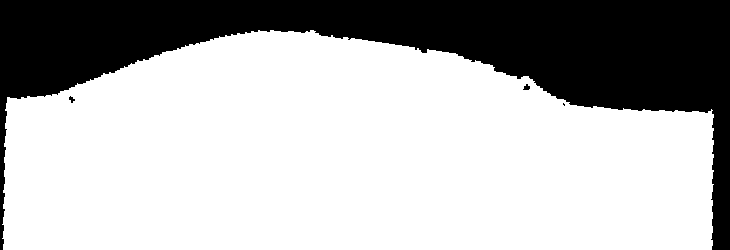

In [85]:
## cut the image,0].numpy()*255
original = data_input[750].numpy().reshape((250,730))*255
Image.fromarray(original.astype('uint8'), 'L')

In [86]:
## data_input[0,:,:,:].shape

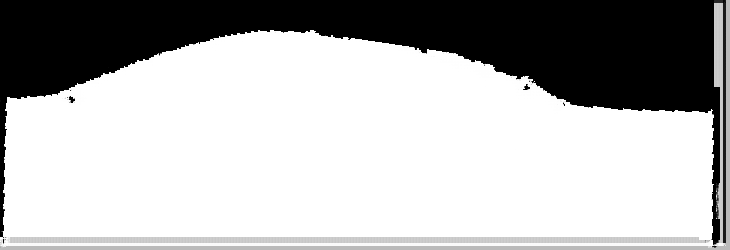

In [87]:
predict = output[0,0].numpy()*255
Image.fromarray(predict.astype('uint8'), 'L')

In [69]:
## output[0,0].numpy()

In [70]:
## data_input[0,0].numpy()

In [90]:
output[0]

torch.Size([1, 250, 730])

In [97]:
F.mse_loss(output[0].reshape(1,-1), data[0].reshape(1,-1))

tensor(0.0129, device='cuda:0')

In [101]:
output[0].reshape(1,-1)

tensor([[0.2231, 0.1729, 0.2417,  ..., 0.6798, 0.6798, 0.6798]],
       device='cuda:0')

In [98]:
data[0].reshape(1,-1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

### reload and test

In [18]:
data_input.shape

torch.Size([4046, 1, 250, 730])

In [19]:
model.load_state_dict(torch.load('conv_small_kernel_without_timeaxis_bce.pth'))

<All keys matched successfully>

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
## extract encoder layers by hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

In [22]:
model.Conv_NN_encoder.register_forward_hook(get_activation('Conv_NN_encoder'))

In [23]:
extract_rlt = []

for i in tqdm(range(data_input.shape[0])):
    data = data_input[i:i+1]
    data = data.to(device)
    output = model(data)
    encoder_ = activation['Conv_NN_encoder'].cpu().numpy()
    extract_rlt.append(encoder_.flatten())

  0%|          | 0/4046 [00:00<?, ?it/s]

In [24]:
extract_rlt[0].shape

(6,)

In [25]:
ext_rlt = np.array(extract_rlt)

In [26]:
np.save("ext_ft_sml_knl.npy", ext_rlt)

### projection

In [205]:
# try pca to reduce dimension
from sklearn.decomposition import PCA

In [207]:
pca = PCA(n_components=2)
pca.fit(ext_rlt)

PCA(n_components=2)

In [208]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

[0.39804947 0.24015431]
[3244.4143 1957.4453]


In [209]:
valid_ = pca.transform(ext_rlt)

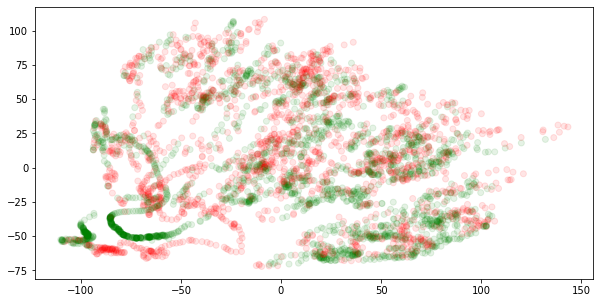

In [210]:
plt.figure(figsize=(10,5))
plt.scatter(valid_[:, 0], valid_[:, 1],marker='o', alpha=0.1, color=color)
plt.show()

In [116]:
valid_[0], valid_[350], valid_[351], valid_[100]

(array([-93.52829 , -33.32816 ,  17.429016,  13.216734], dtype=float32),
 array([-59.731857, -11.349767, -10.643011, -41.794975], dtype=float32),
 array([-57.992638, -10.178789, -11.430878, -43.737404], dtype=float32),
 array([-100.55785 ,  -53.36214 ,   16.361658,  -12.974073], dtype=float32))

In [117]:
### kernel pca

In [196]:
from sklearn.decomposition import KernelPCA as kpca

In [197]:
pca = kpca(n_components=2, kernel='rbf')
pca.fit(ext_rlt)

KernelPCA(kernel='rbf', n_components=2)

In [198]:
valid_ = pca.transform(ext_rlt)

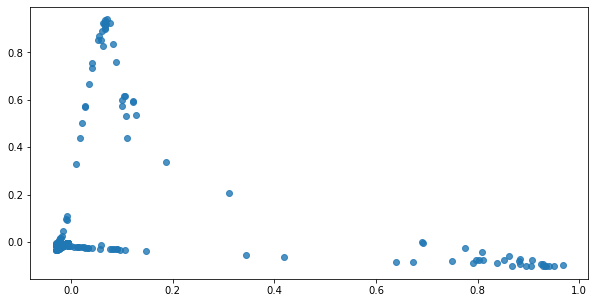

In [199]:
plt.figure(figsize=(10,5))
plt.scatter(valid_[:, 0], valid_[:, 1],marker='o', alpha=0.8)
plt.show()

### using mean

In [123]:
## step = 5
## 
## def sliding_window(datas,steps=1,width=step):
##     win_set=[]
##     for i in tqdm(np.arange(0,len(datas),steps)):
##         temp=datas[i:i+width]
##         if temp.shape[0] == width:
##             win_set.append(temp.mean())
##     return np.array(win_set)

In [124]:
## mean_rlt = sliding_window(ext_rlt,steps=5,width=step)

In [125]:
## plt.scatter(range(mean_rlt.shape[0]), mean_rlt)
## plt.show()

### mapping with label

In [127]:
label = np.load('label_01.npy')

In [226]:
np.sum(label)# / label.shape[0]

1895

In [129]:
ext_rlt.shape

(4046, 6)

In [130]:
from scipy import spatial

In [146]:
spatial.distance.cosine(label, ext_rlt[:,1])

0.47479443179725667

In [145]:
spatial.distance.cosine(label, ext_rlt[:,5])

0.8425052036004214

In [148]:
color = ['green' if i==0 else 'red' for i in label]

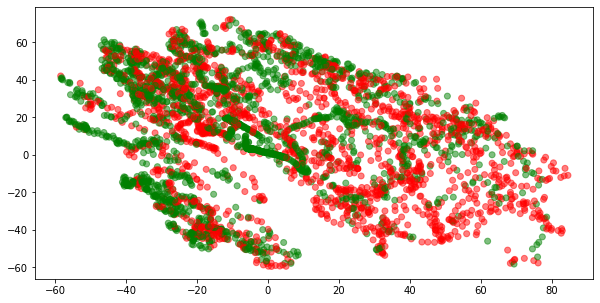

In [215]:
plt.figure(figsize=(10,5))
plt.scatter(ext_rlt[:, 0], ext_rlt[:, 5],marker='o', alpha=0.5, color=color)
plt.show()

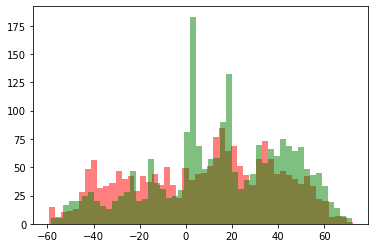

In [193]:
plt.hist(ext_rlt[:,5][np.where(np.array(label) == 1)[0]], bins=50, alpha=0.5, color='red')
plt.hist(ext_rlt[:,5][np.where(np.array(label) == 0)[0]], bins=50, alpha=0.5, color='green')
plt.show()

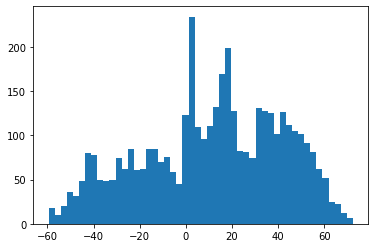

In [32]:
plt.hist(ext_rlt[:,5], bins=50)
plt.show()

In [194]:
np.where(np.array(label) == 1)[0]#,np.where(np.array(label) == 1)[0]

array([ 112,  113,  118, ..., 3782, 3801, 3834], dtype=int64)

In [195]:
np.where(np.array(label) == 0)[0]

array([   0,    1,    2, ..., 4043, 4044, 4045], dtype=int64)

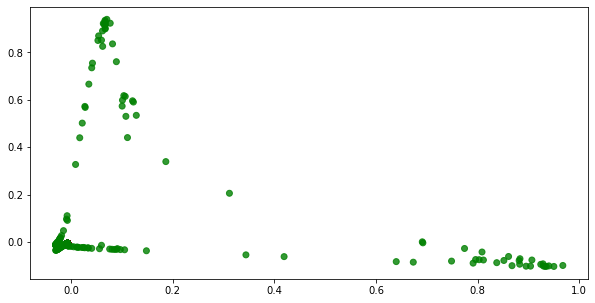

In [200]:
plt.figure(figsize=(10,5))
plt.scatter(valid_[:, 0], valid_[:, 1],marker='o', alpha=0.8, color=color)
plt.show()